In [116]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

In [117]:
# Download the dataset
dataframe = pd.read_csv('all_data.csv')
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
0,338.0,334.0,331.0,328.0,324.0,330.0,318.0,314.0,311.0,308.0,...,525.0,534.0,522.0,508.0,507.0,529.0,528.0,531.0,506.0,0
1,501.0,492.0,492.0,490.0,471.0,462.0,442.0,428.0,419.0,413.0,...,537.0,532.0,522.0,522.0,522.0,492.0,492.0,490.0,491.0,0
2,489.0,487.0,463.0,447.0,447.0,421.0,406.0,398.0,395.0,388.0,...,525.0,512.0,508.0,491.0,494.0,494.0,484.0,482.0,482.0,0
3,468.0,456.0,456.0,438.0,426.0,409.0,405.0,392.0,383.0,383.0,...,501.0,494.0,494.0,484.0,466.0,466.0,450.0,450.0,445.0,0
4,443.0,434.0,417.0,398.0,379.0,360.0,360.0,339.0,330.0,325.0,...,435.0,407.0,407.0,387.0,387.0,372.0,370.0,366.0,360.0,0


In [118]:
dataframe.shape

(738, 97)

In [119]:
dataframe.head(2)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
0,338.0,334.0,331.0,328.0,324.0,330.0,318.0,314.0,311.0,308.0,...,525.0,534.0,522.0,508.0,507.0,529.0,528.0,531.0,506.0,0
1,501.0,492.0,492.0,490.0,471.0,462.0,442.0,428.0,419.0,413.0,...,537.0,532.0,522.0,522.0,522.0,492.0,492.0,490.0,491.0,0


In [120]:
dataframe_1 = dataframe.iloc[4:5, :-1]

In [121]:
dataframe_1

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
4,443.0,434.0,417.0,398.0,379.0,360.0,360.0,339.0,330.0,325.0,...,435.0,435.0,407.0,407.0,387.0,387.0,372.0,370.0,366.0,360.0


In [122]:
series = dataframe_1.values
series = series.tolist()


In [123]:
flat_list = [item for sublist in series for item in sublist]

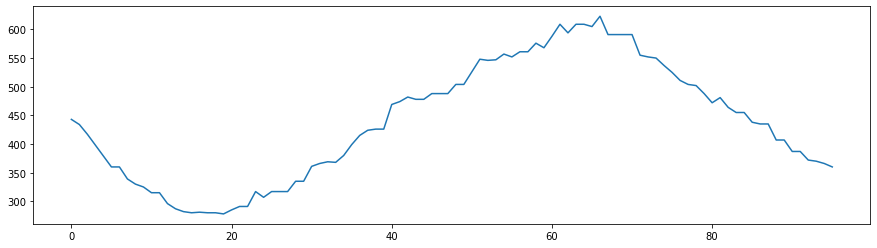

In [124]:
plt.figure(figsize = (15, 4))
plt.plot(flat_list)
plt.show()

In [125]:
# The last element contains the labels
labels = raw_data[:, -1]


data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

#train_data, test_data, train_labels, test_labels = data[34:], data[:34], labels[34:], labels[:34]

In [126]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [127]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
print(normal_test_data)
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

tf.Tensor(
[[0.1257485  0.11377245 0.10329341 ... 0.13922156 0.14071856 0.14071856]
 [0.27994013 0.2709581  0.25       ... 0.20658682 0.19760479 0.20508982]
 [0.36826348 0.37125748 0.36077845 ... 0.35179642 0.35329342 0.35628742]
 ...
 [0.16317365 0.16317365 0.16317365 ... 0.1721557  0.17814371 0.1721557 ]
 [0.16916168 0.16916168 0.16916168 ... 0.17814371 0.1721557  0.1751497 ]
 [0.30688623 0.30688623 0.30988023 ... 0.31437126 0.31586826 0.3203593 ]], shape=(144, 96), dtype=float32)


In [128]:
anomalous_test_data.shape

TensorShape([4, 96])

In [129]:
normal_test_data.shape

TensorShape([144, 96])

### Build the model

In [147]:
class Detector(Model):
    def __init__(self):
        super(Detector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(8, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(96, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Detector()

In [143]:
autoencoder.compile(optimizer='adam', loss='mae')

In [144]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=200, 
          batch_size=32,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/200
18/18 [==============================] - 1s 10ms/step - loss: 0.2747 - val_loss: 0.2653
Epoch 2/200
18/18 [==============================] - 0s 3ms/step - loss: 0.2367 - val_loss: 0.1882
Epoch 3/200
18/18 [==============================] - 0s 3ms/step - loss: 0.1577 - val_loss: 0.1412
Epoch 4/200
18/18 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1245
Epoch 5/200
18/18 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.1151
Epoch 6/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0998 - val_loss: 0.1024
Epoch 7/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0800
Epoch 8/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0641 - val_loss: 0.0627
Epoch 9/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0476
Epoch 10/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0392
Epoch 11

18/18 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0195
Epoch 84/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0195
Epoch 85/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0195
Epoch 86/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0195
Epoch 87/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0164 - val_loss: 0.0194
Epoch 88/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0193
Epoch 89/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0195
Epoch 90/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0194
Epoch 91/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0195
Epoch 92/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0193
Epoch 93/200


18/18 [==============================] - 0s 3ms/step - loss: 0.0161 - val_loss: 0.0193
Epoch 165/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0192
Epoch 166/200
18/18 [==============================] - 0s 4ms/step - loss: 0.0162 - val_loss: 0.0192
Epoch 167/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0161 - val_loss: 0.0194
Epoch 168/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0194
Epoch 169/200
18/18 [==============================] - 0s 4ms/step - loss: 0.0161 - val_loss: 0.0193
Epoch 170/200
18/18 [==============================] - 0s 4ms/step - loss: 0.0161 - val_loss: 0.0192
Epoch 171/200
18/18 [==============================] - 0s 4ms/step - loss: 0.0161 - val_loss: 0.0193
Epoch 172/200
18/18 [==============================] - 0s 4ms/step - loss: 0.0160 - val_loss: 0.0192
Epoch 173/200
18/18 [==============================] - 0s 4ms/step - loss: 0.0161 - val_loss: 0.0192
Epoc

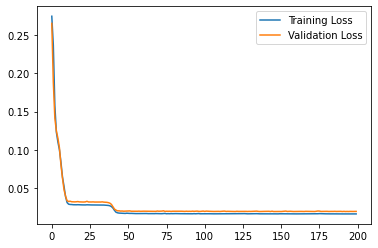

In [145]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

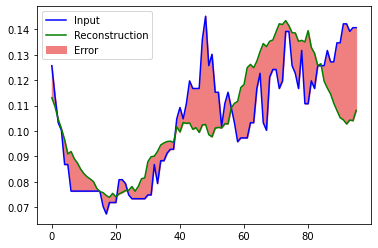

In [146]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'g')
plt.fill_between(np.arange(96), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [135]:
err_normal = decoded_data[0] - normal_test_data[0]
np.mean(err_normal)

-0.0010003598

- You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.




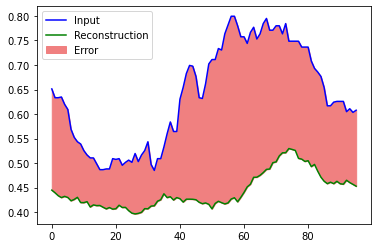

In [136]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'g')
plt.fill_between(np.arange(96), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [137]:
err_anormal = decoded_data[0] -  anomalous_test_data[0]
np.mean(err_anormal)

-0.19507842

In [138]:
anomalous_test_data[2]

<tf.Tensor: shape=(96,), dtype=float32, numpy=
array([0.19910179, 0.18413174, 0.18113773, 0.1751497 , 0.17065868,
       0.17065868, 0.15868263, 0.15269461, 0.1497006 , 0.15269461,
       0.15568863, 0.15568863, 0.1482036 , 0.14071856, 0.13323353,
       0.13473053, 0.1482036 , 0.1482036 , 0.15718563, 0.19461077,
       0.19461077, 0.19461077, 0.22155689, 0.19760479, 0.2020958 ,
       0.19910179, 0.19910179, 0.18862276, 0.19610779, 0.18413174,
       0.20958084, 0.23353294, 0.24401198, 0.2754491 , 0.31437126,
       0.31287426, 0.2994012 , 0.2994012 , 0.2949102 , 0.33233532,
       0.33532935, 0.36526945, 0.38922155, 0.36676645, 0.37125748,
       0.37125748, 0.4071856 , 0.4491018 , 0.45808384, 0.48652694,
       0.48203593, 0.498503  , 0.498503  , 0.5329341 , 0.53892213,
       0.5449102 , 0.4775449 , 0.46407187, 0.4505988 , 0.43263474,
       0.4505988 , 0.4505988 , 0.45808384, 0.45658684, 0.47005987,
       0.46706587, 0.51047903, 0.5703593 , 0.5643712 , 0.58832335,
       0.588323

In [139]:
arr1 = np.array([[1, 2, 3],
                 [3, 2, 1]])
                 
arr2 = np.array([[1, 2, 3],
                 [3, 2, 1]])    

In [140]:
arr1-arr2

array([[0, 0, 0],
       [0, 0, 0]])